In [1]:
import os
import pickle

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell

from hbmep.model import BaseModel
from hbmep import functional as F
from hbmep.util import site

InteractiveShell.ast_node_interactivity = "all"
ignore_warnings = np.errstate(divide='ignore',invalid='ignore')

HOME = os.getenv("HOME")
EXPERIMENT = "lshie" # lcirc, csmalar

MODEL_DIR = f"{HOME}/reports/hbmep/notebooks/rat/lognhb/nhb__4000w_1000s_4c_1t_20d_95a_tm/{EXPERIMENT}/rectified_logistic"
INFERENCE_FILE = os.path.join(MODEL_DIR, "inference.pkl")
MODEL_FILE = os.path.join(MODEL_DIR, "model.pkl")
EXPERIMENT_TOML_MAP = {"lcirc": "L_CIRC", "lshie": "L_SHIE", "csmalar": "C_SMA_LAR"}
TOML_PATH = f"{HOME}/repos/rat-mapping-paper/configs/{EXPERIMENT_TOML_MAP[EXPERIMENT]}.toml"

MAX_INTENSITY = 9 # 2 ** 9 = 512
MAX_INTENSITY = 14 # 2 ** 9 = 512
NUM_POINTS = 200 # reduce if ram overflows


/home/vishu/repos/refactor/hbmep/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
src = INFERENCE_FILE
with open(src, "rb") as f:
    df, encoder, posterior, _ = pickle.load(f)

src = MODEL_FILE
with open(src, "rb") as f:
    model, = pickle.load(f)


In [4]:
a = posterior[site.a]
b = posterior[site.b]
g = posterior[site.g]
h = posterior[site.h]
v = posterior[site.v]

x = np.arange(0, MAX_INTENSITY, .05)

named_params = [site.a, site.b, site.g, site.h, site.v]
params = [posterior[param][ ...] for param in named_params]
params = [param[None, ...] for param in params] # add extra axis for x values
params[2] = params[2] * 0 # get rid of noise floor (baseline value)

subjects = sorted(df['participant'].unique())
subjects_inverse = encoder['participant'].inverse_transform(subjects).tolist()
subjects_inverse

positions = sorted(df['compound_position'].unique())
positions_inverse = encoder['compound_position'].inverse_transform(positions).tolist()
positions_inverse

charges = sorted(df["compound_charge_params"].unique())     # Sort the encoded charges so they are in the same order as the posterior samples
charges_inverse = encoder['compound_charge_params'].inverse_transform(charges).tolist()     # Then decode the charges, this maintains the order of the charges
charges_inverse


['amap01',
 'amap02',
 'amap03',
 'amap04',
 'amap05',
 'amap06',
 'amap07',
 'amap08']

['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC']

['20-0-80-25', '50-0-50-100']

In [5]:
max_intensity_df = df.groupby(by=model.features, as_index=False).agg({model.intensity: np.max})
keys = max_intensity_df[model.features].apply(tuple, axis=1).values.tolist()
values = max_intensity_df[model.intensity].values.tolist()
max_intensity_map = dict(zip(keys, values))

num_features = df[model.features].to_numpy().max(axis=0) + 1
max_intensity = np.full(num_features, np.nan)
for u, v in max_intensity_map.items(): max_intensity[*u] = v


In [6]:
# Response
y = np.array(F.rectified_logistic(
    x[:, *(None for _ in range(a.ndim))], *params
))
y.shape

# # Get max
# y_max = np.nanmax(y, axis=(0, 3, 4), keepdims=True)
# y_max.shape
y_max = np.array(F.rectified_logistic(
    max_intensity[None, None, ..., None], *params
))
y_max.shape

# Normalize
with ignore_warnings:
    y_norm = np.where(y_max, y / y_max, 0.)
    y = y_norm.copy()
    y.shape


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(280, 4000, 8, 4, 2, 6)

(1, 4000, 8, 4, 2, 6)

(280, 4000, 8, 4, 2, 6)

In [7]:
# Calculate selectivity
p = np.nansum(y, axis=-1, keepdims=True)
p.shape

with ignore_warnings:
    p = np.where(p, y / p, 1 / y.shape[-1])
    p.shape

with ignore_warnings:
    plogp = np.where(p, p * np.log(p), 0)
    plogp.shape

entropy = 1 + (plogp.sum(axis=-1) / np.log(y.shape[-1]))
entropy.shape

np.isnan(entropy).sum()
auc = np.trapz(y=entropy, x=x, axis=0)
auc.shape


(280, 4000, 8, 4, 2, 1)

(280, 4000, 8, 4, 2, 6)

(280, 4000, 8, 4, 2, 6)

(280, 4000, 8, 4, 2)

0

(4000, 8, 4, 2)

In [8]:
from scipy.integrate import cumulative_trapezoid
cum_auc = cumulative_trapezoid(y=entropy, x=x, axis=0)


In [9]:
cum_auc.shape


(279, 4000, 8, 4, 2)

In [10]:
# Transpose trick to get pairwise diffs
# auc_reshaped = auc.reshape(*auc.shape[:2], -1)
auc_reshaped = cum_auc.reshape(*cum_auc.shape[:-2], -1)
auc_reshaped.shape

labels = []
for pos in positions_inverse:
    for charge in charges_inverse:
        labels.append(f"{pos}__{charge[:2]}")

diff = auc_reshaped[..., None] - auc_reshaped[..., None, :]
diff.shape


(279, 4000, 8, 8)

(279, 4000, 8, 8, 8)

In [11]:
from numpyro.diagnostics import hpdi


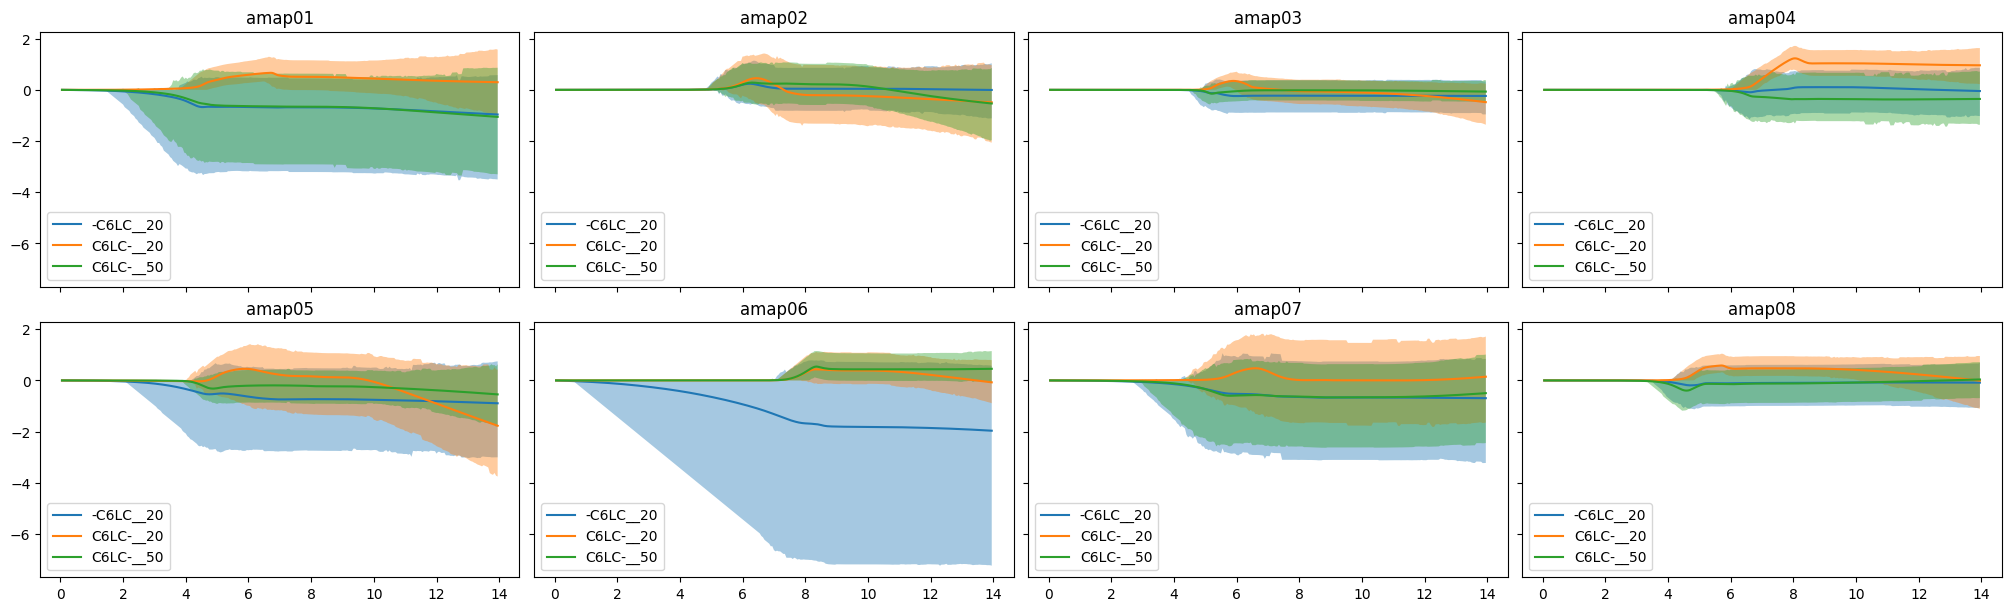

In [12]:
reference = 1
diff_from_reference = diff[..., reference, :]
diff_from_reference.shape

diff_from_reference_hdi = hpdi(diff_from_reference, prob=.95, axis=1)
diff_from_reference_hdi.shape

subset = range(4, 8)
subset = range(0, 4)

nr, nc = 2, 4
fig, axes = plt.subplots(
    nr, nc, figsize=(5 * nc, 3 * nr), constrained_layout=True, squeeze=False, sharex=True, sharey=True
)
counter = 0
for subject_idx, subject in enumerate(subjects_inverse):
    ax = axes[counter // nc, counter % nc]

    for label_idx in subset:
        label = labels[label_idx]
        if label_idx == reference: continue
        curr_diff = diff_from_reference[...,  subject_idx, label_idx]
        curr_diff_hdi = diff_from_reference_hdi[..., subject_idx, label_idx]
        ax.fill_between(x[1:], curr_diff_hdi[:, 0], curr_diff_hdi[:, 1], alpha=.4)
        sns.lineplot(x=x[1:], y=curr_diff.mean(axis=-1), label=label, ax=ax);

    ax.set_title(subject);
    counter += 1

plt.show();


In [ ]:
diff_copy = diff.copy()


In [ ]:
diff = diff_copy[x[1:] == 6.5][0, ...]

# Mask out diagonal entries
it = np.nditer(diff[..., 0, 0], flags=['multi_index'])
while not it.finished:
    index = it.multi_index
    np.fill_diagonal(diff[index], np.nan)
    _ = it.iternext()
diff.shape

# Get rid of posterior samples by taking mean
diff = np.nanmean(diff, axis=0)
diff.shape


IndexError: boolean index did not match indexed array along dimension 0; dimension is 4000 but corresponding boolean dimension is 279

In [9]:
test = stats.wilcoxon(diff, axis=0)
pvalue = test.pvalue
pvalue = mask(pvalue)
pvalue.shape

_test = stats.ttest_1samp(diff, popmean=0)
statistic = _test.statistic
statistic = mask(statistic)
statistic.shape

deg = _test.df
deg = mask(deg)
deg.shape


(8, 8)

(8, 8)

(8, 8)

/tmp/ipykernel_243707/3253829279.py:9: RuntimeWarning: invalid value encountered in cast
  annot(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)


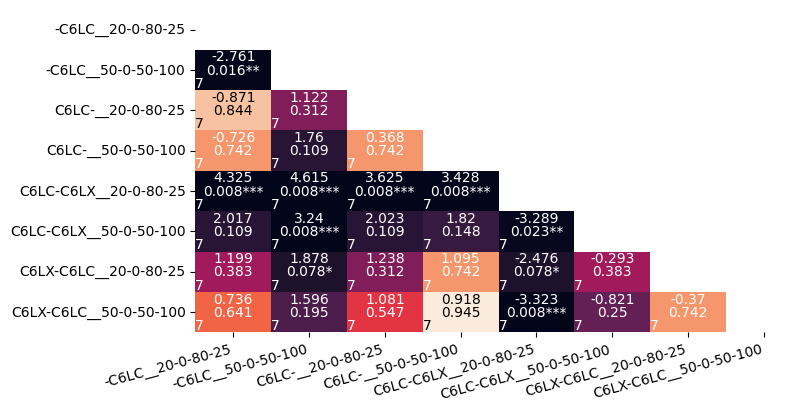

In [10]:
fig, axes = plt.subplots(1, 1, constrained_layout=True, squeeze=False, figsize=(8, 4))
ax = axes[0, 0]
sns.heatmap(pvalue, annot=False, ax=ax, cbar=False)

# Annotate
pvalue_annot_kws = {"ha": 'center', "va": 'center'}
annot(ax, pvalue,  np.round(pvalue, 3), 0.5, 0.5, star=True, star_arr=pvalue, **pvalue_annot_kws)
deg_annot_kws = {"ha": 'left', "va": 'bottom'}
annot(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)
statistic_annot_kws = {"ha": 'center', "va": 'top'}
annot(ax, pvalue, np.round(statistic, 3), 0.5, 0, **statistic_annot_kws)
ax.set_xticklabels(labels=labels, rotation=15, ha="right");
ax.set_yticklabels(labels=labels, rotation=0);


In [11]:
auc.shape

(4000, 8, 4, 2)

In [20]:
t = (auc[..., 2, 1] - auc[..., 0, 1]).nanmean(axis=0)
t.shape

stats.wilcoxon(t).pvalue

stats.ttest_1samp(t, popmean=0).statistic


(8,)

0.015625

2.1372135629649045

In [15]:
positions_inverse
charges_inverse

['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC']

['20-0-80-25', '50-0-50-100']

In [14]:
positions_inverse

['-C6LC', 'C6LC-', 'C6LC-C6LX', 'C6LX-C6LC']

In [ ]:
auckkkkkk